# Analisis de sentimientos con Naive Bayes

In [22]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [2]:
# Exploracion de datos
df = pd.read_csv('/home/jgaviria/Workspace/DataScience/datasets/complaints.csv')
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
8,2020-04-30,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,I am disputing this information. And seeking r...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,OH,432XX,NaN,Consent provided,Web,2020-04-30,Closed with explanation,Yes,NaN,3630931
11,2019-09-08,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,NaN,"I was sold access to an event digitally, of wh...",NaN,"Paypal Holdings, Inc",RI,029XX,NaN,Consent provided,Web,2019-09-08,Closed with explanation,Yes,NaN,3366475


In [3]:
df.count()

Date received                   530850
Product                         530850
Sub-product                     478678
Issue                           530850
Sub-issue                       397893
Consumer complaint narrative    530850
Company public response         260522
Company                         530850
State                           528828
ZIP code                        411921
Tags                             90786
Consumer consent provided?      530850
Submitted via                   530850
Date sent to company            530850
Company response to consumer    530849
Timely response?                530850
Consumer disputed?              164066
Complaint ID                    530850
dtype: int64

In [8]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()

,Product,Consumer_complaint_narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,1
3,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
8,"Credit reporting, credit repair services, or o...",I am disputing this information. And seeking r...,1
11,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh...",2


In [14]:
df = df.head(50)

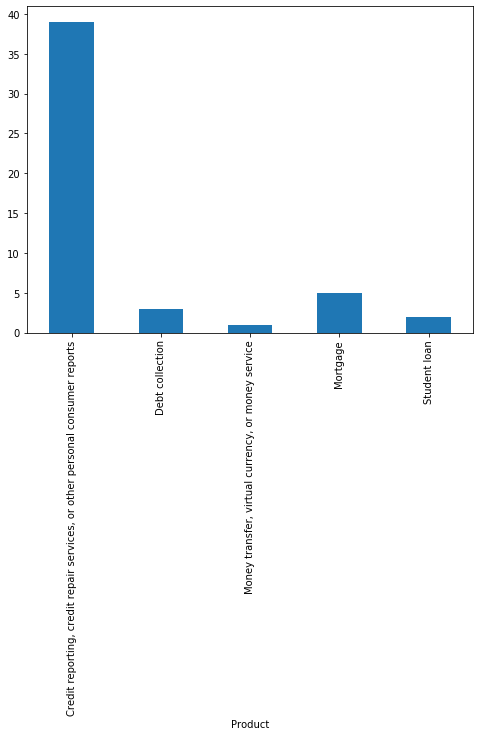

In [15]:
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [16]:
df.groupby('Product').Consumer_complaint_narrative.count()

Product
Credit reporting, credit repair services, or other personal consumer reports    39
Debt collection                                                                  3
Money transfer, virtual currency, or money service                               1
Mortgage                                                                         5
Student loan                                                                     2
Name: Consumer_complaint_narrative, dtype: int64

In [17]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(50, 101)

In [18]:
features

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.33159434, 0.        ,
        0.33791895],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.18449033, 0.        , ..., 0.21862465, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.22983278, 0.        ,
        0.22056018]])

In [21]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. days
. following
  . Most correlated bigrams:
. fair credit
. xxxx xxxx
# 'Checking or savings account':
  . Most correlated unigrams:
. days
. following
  . Most correlated bigrams:
. fair credit
. xxxx xxxx
# 'Consumer Loan':
  . Most correlated unigrams:
. days
. following
  . Most correlated bigrams:
. fair credit
. xxxx xxxx
# 'Credit card':
  . Most correlated unigrams:
. days
. following
  . Most correlated bigrams:
. fair credit
. xxxx xxxx
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. days
. following
  . Most correlated bigrams:
. fair credit
. xxxx xxxx
# 'Credit reporting':
  . Most correlated unigrams:
. days
. following
  . Most correlated bigrams:
. fair credit
. xxxx xxxx
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
. loan
. mortgage
  . Most correlated bigrams:
. xx xx
. xx xxxx
# 'Debt collection':
  . Most correlated unigr

In [23]:
# Clasificador Naive Bayes
count_vect = CountVectorizer()
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)

In [24]:
X_train.count()

37

In [25]:
X_test

54    The credit bureaus are reporting inaccurate/ou...
20    MY NAME IS XXXX XXXX XXXX I live at XXXX XXXX ...
19    I would like the credit bureau to correct my X...
81    Contacted 6 times regarding incorrect reportin...
3     Over the past 2 weeks, I have been receiving e...
53    I have a few situations going on with my credi...
73    XXXX and Transunion are incorrectly reporting ...
60    XX/XX/19 XXXX XXXX XXXX XXXX XXXX XXXX XXXX XX...
38    I am a victim of identity theft. The informati...
11    I was sold access to an event digitally, of wh...
63    The mortgage company ( Roundpoint Mortgageg ) ...
65    I would like too see is if some of the old har...
52    XXXX ; XXXX and Transunion are reporting incor...
Name: Consumer_complaint_narrative, dtype: object

In [26]:
y_train.count()

37

In [27]:
y_test.count()

13

In [ ]:
#Term Frecuency - TF
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)